In [1]:
from data import DATA_3DCD, DATA_MP

PRODUCTION DATA PRESENT


In [2]:
%run ./modules.ipynb

In [3]:
mp_frames = ase.io.read(DATA_MP.structures, index=":")
exp_frames = ase.io.read(DATA_3DCD.structures, index=":")

In [4]:
len(mp_frames), len(exp_frames)

(83989, 79854)

In [5]:
natoms_mp = np.zeros(len(mp_frames), dtype=int)
natoms_exp = np.zeros(len(exp_frames), dtype=int)

for i, frame in enumerate(tqdm(mp_frames)):
    frame.wrap(eps=1e-10)
    natoms_mp[i] = len(frame)

for i, frame in enumerate(tqdm(exp_frames)):
    frame.wrap(eps=1e-10)
    natoms_exp[i] = len(frame)

  0%|          | 0/83989 [00:00<?, ?it/s]

  0%|          | 0/79854 [00:00<?, ?it/s]

In [6]:
# import PIL
# from mpl_toolkits.axes_grid1.inset_locator import inset_axes
# mat_project_logo = PIL.Image.open('mat_proj_logo.png')
# m3dcd_logo = PIL.Image.open('5eb44b50.mc3d.png')

In [7]:
# n_magic_mp = len(np.where(natoms_mp%4==0)[0])
# n_nonmagic_mp = len(np.where(natoms_mp%4!=0)[0])

# n_magic_3dcd = len(np.where(natoms_exp%4==0)[0])
# n_nonmagic_3dcd = len(np.where(natoms_exp%4!=0)[0])

In [8]:
# sns.set(style="white", palette="muted", color_codes=True)

# fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8))
# sns.histplot(ax=ax2, data=natoms_mp, stat="probability", bins=int(natoms_mp.max()))
# sns.histplot(ax=ax1, data=natoms_exp, stat="probability", bins=int(natoms_exp.max()))

# mat_inset = inset_axes(ax1, width="50%", height="40%", borderpad=1, loc='upper right')
# mat_inset.imshow(mat_project_logo)
# mat_inset.axis('off')
# mat_inset.text(x=0.5, y=-0.05, ha='center', va='top', 
#                  s='The Materials Project (MP)',
#                  fontsize=12,
#                  transform=mat_inset.transAxes)
# mat_inset.text(x=0.5, y=-0.225, ha='center', va='top', 
#                  s='$n_{{\\rm{{magic}}}}$={}, $n_{{\\rm{{non-magic}}}}$={}'.format(n_magic_mp, n_nonmagic_mp),
#                  fontsize=10,
#                  transform=mat_inset.transAxes)

# m3dcd_inset = inset_axes(ax2, width="50%", height="50%", borderpad=1, loc='upper right')
# m3dcd_inset.imshow(m3dcd_logo)
# m3dcd_inset.axis('off')
# m3dcd_inset.text(x=0.5, y=0.0, ha='center', va='top', 
#                  s='Materials Cloud three-dimensional\ncrystals database (MC3D)',
#                  fontsize=12,
#                  transform=m3dcd_inset.transAxes)
# m3dcd_inset.text(x=0.5, y=-0.25, ha='center', va='top', 
#                  s='$n_{{\\rm{{magic}}}}$={}, $n_{{\\rm{{non-magic}}}}$={}'.format(n_magic_3dcd, n_nonmagic_3dcd),
#                  fontsize=10,
#                  transform=m3dcd_inset.transAxes)
# sns.despine(left=True, bottom=True)
# ax1.set_xlim(0, 100)
# ax2.set_xlim(0, 100)
# ax2.set_xlabel(r"$N_{atoms, cell}$")

# plt.savefig('natoms1.png')

In [9]:
ns = range(3, 20)
n_magic_all_mp = np.zeros(len(ns))
n_magic_all_3dcd = np.zeros(len(ns))
n_nmagic_all_mp = np.zeros(len(ns))
n_nmagic_all_3dcd = np.zeros(len(ns))
for i, v in enumerate(tqdm(ns)):
    n_magic_all_mp[i] = len(np.where(natoms_mp%v==0)[0])
    n_magic_all_3dcd[i] = len(np.where(natoms_exp%v==0)[0])
    n_nmagic_all_mp[i] = len(np.where(natoms_mp%v!=0)[0])
    n_nmagic_all_3dcd[i] = len(np.where(natoms_exp%v!=0)[0])

  0%|          | 0/17 [00:00<?, ?it/s]

In [10]:
from spglib import find_primitive

In [11]:
tols = np.array(list(sorted([*np.logspace(-8, 0, 9), 0.2, 0.5, 0.8])))
save_period = 1000
tols

array([1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01,
       2.e-01, 5.e-01, 8.e-01, 1.e+00])

In [12]:
if os.path.exists('mp_symms.npy'):
    mp_symm = np.array(np.load('mp_symms.npy'), dtype=float)
    mp_symm[mp_symm<0]=np.nan
else:
    mp_symm = np.zeros((len(tols), len(mp_frames)), dtype=float)
    
for next_tol in np.where(np.nanmin(mp_symm, axis=1)==0)[0]:
    if mp_symm[next_tol][0]!=0.0:
        print(len(np.where(mp_symm[next_tol]==0)[0]))
        i = np.where(mp_symm[next_tol]==0)[0][0]
        mp_symm[next_tol][i] = np.nan
        np.save('mp_symms.npy', mp_symm)
        save_period = 1
    print(tols, tols[next_tol], save_period)

    for i, cell in enumerate(tqdm(mp_frames)):
        if mp_symm[next_tol][i] == 0:
            prim = find_primitive((cell.get_cell(), 
                                   cell.get_scaled_positions(), 
                                   cell.get_atomic_numbers()), 
                                  symprec=tols[next_tol])
            mp_symm[next_tol][i] = len(prim[2]) if prim is not None else np.nan
            if i%save_period==0:
                np.save('mp_symms.npy', mp_symm)
            if save_period==1 and i%1000==0:
                save_period=1000

988
[1.e-08 1.e-07 1.e-06 1.e-05 1.e-04 1.e-03 1.e-02 1.e-01 2.e-01 5.e-01
 8.e-01 1.e+00] 0.8 1


  0%|          | 0/83989 [00:00<?, ?it/s]

In [13]:
if os.path.exists('exp_symms.npy'):
    exp_symm = np.array(np.load('exp_symms.npy'), dtype=float)
    exp_symm[exp_symm<0]=np.nan
else:
    exp_symm = np.zeros((len(tols), len(exp_frames)), dtype=float)
    
for next_tol in np.where(np.nanmin(exp_symm, axis=1)==0)[0]:
    if exp_symm[next_tol][0]!=0.0:
        print(len(np.where(exp_symm[next_tol]==0)[0]))
        i = np.where(exp_symm[next_tol]==0)[0][0]
        exp_symm[next_tol][i] = np.nan
        np.save('exp_symms.npy', exp_symm)
        save_period = 1
    print(tols, tols[next_tol])

    for i, cell in enumerate(tqdm(exp_frames)):
        if exp_symm[next_tol][i] == 0:
            prim = find_primitive((cell.get_cell(), cell.get_scaled_positions(), cell.get_atomic_numbers()), symprec=tols[next_tol])
            exp_symm[next_tol][i] = len(prim[2]) if prim is not None else np.nan
            if i%save_period==0:
                np.save('exp_symms.npy', exp_symm)
            if save_period==1 and i%1000==0:
                save_period=1000

853
[1.e-08 1.e-07 1.e-06 1.e-05 1.e-04 1.e-03 1.e-02 1.e-01 2.e-01 5.e-01
 8.e-01 1.e+00] 0.8


  0%|          | 0/79854 [00:00<?, ?it/s]

In [14]:
perc_flip_mp = [1 - len(np.where(mp_symm[i]%4==0)[0])/len(np.where(natoms_mp%4==0)[0]) if min(mp_symm[i])>0 else np.nan for i in range(len(tols))]
perc_flip_exp = [1 - len(np.where(exp_symm[i]%4==0)[0])/len(np.where(natoms_exp%4==0)[0]) if min(exp_symm[i])>0 else np.nan for i in range(len(tols))]

<ipython-input-14-09e38c3bf851>:1: RuntimeWarning: invalid value encountered in remainder
  perc_flip_mp = [1 - len(np.where(mp_symm[i]%4==0)[0])/len(np.where(natoms_mp%4==0)[0]) if min(mp_symm[i])>0 else np.nan for i in range(len(tols))]
<ipython-input-14-09e38c3bf851>:2: RuntimeWarning: invalid value encountered in remainder
  perc_flip_exp = [1 - len(np.where(exp_symm[i]%4==0)[0])/len(np.where(natoms_exp%4==0)[0]) if min(exp_symm[i])>0 else np.nan for i in range(len(tols))]


In [15]:
if os.path.exists('mono_mp_symms.npy'):
    mono_mp_symm = np.array(np.load('mono_mp_symms.npy'), dtype=float)
    mono_mp_symm[mono_mp_symm<0]=np.nan
else:
    mono_mp_symm = np.zeros((len(tols), len(mp_frames)), dtype=float)
    
for next_tol in np.where(np.nanmin(mono_mp_symm, axis=1)==0)[0]:
    if mono_mp_symm[next_tol][0]!=0.0:
        print(len(np.where(mono_mp_symm[next_tol]==0)[0]))
        i = np.where(mono_mp_symm[next_tol]==0)[0][0]
        mono_mp_symm[next_tol][i] = np.nan
        np.save('mono_mp_symms.npy', mono_mp_symm)
        save_period = 1
    print(tols, tols[next_tol], save_period)

    for i, cell in enumerate(tqdm(mp_frames)):
        if mono_mp_symm[next_tol][i] == 0:
            prim = find_primitive((cell.get_cell(), 
                                   cell.get_scaled_positions(), 
                                   np.ones(len(cell))), 
                                  symprec=tols[next_tol])
            mono_mp_symm[next_tol][i] = len(prim[2]) if prim is not None else np.nan
            if i%save_period==0:
                np.save('mono_mp_symms.npy', mono_mp_symm)
            if save_period==1 and i%1000==0:
                save_period=1000

In [16]:
if os.path.exists('mono_exp_symms.npy'):
    mono_exp_symm = np.array(np.load('mono_exp_symms.npy'), dtype=float)
    mono_exp_symm[mono_exp_symm<0]=np.nan
else:
    mono_exp_symm = np.zeros((len(tols), len(exp_frames)), dtype=float)
    
for next_tol in np.where(np.nanmin(mono_exp_symm, axis=1)==0)[0]:
    if mono_exp_symm[next_tol][0]!=0.0:
        print(len(np.where(mono_exp_symm[next_tol]==0)[0]))
        i = np.where(mono_exp_symm[next_tol]==0)[0][0]
        mono_exp_symm[next_tol][i] = np.nan
        np.save('mono_exp_symms.npy', mono_exp_symm)
        save_period = 1
    print(tols, tols[next_tol], save_period)

    for i, cell in enumerate(tqdm(exp_frames)):
        if mono_exp_symm[next_tol][i] == 0:
            prim = find_primitive((cell.get_cell(), 
                                   cell.get_scaled_positions(), 
                                   np.ones(len(cell))), 
                                  symprec=tols[next_tol])
            mono_exp_symm[next_tol][i] = len(prim[2]) if prim is not None else np.nan
            if i%save_period==0:
                np.save('mono_exp_symms.npy', mono_exp_symm)
            if save_period==1 and i%1000==0:
                save_period=1000

In [17]:
j = np.where(tols==1E-5)[0]
default_mono_mp_symm = mono_mp_symm[j]
default_mono_exp_symm = mono_exp_symm[j]
perc_flip_mono_mp = (1 - len(np.where(default_mono_mp_symm%4==0)[0])/len(np.where(natoms_mp%4==0)[0]))
perc_flip_mono_exp = (1 - len(np.where(default_mono_exp_symm%4==0)[0])/len(np.where(natoms_exp%4==0)[0]))
perc_flip_mono_mp, perc_flip_mono_exp

<ipython-input-17-3c683a979728>:4: RuntimeWarning: invalid value encountered in remainder
  perc_flip_mono_mp = (1 - len(np.where(default_mono_mp_symm%4==0)[0])/len(np.where(natoms_mp%4==0)[0]))


(0.05428463720957921, 0.029585925308364902)

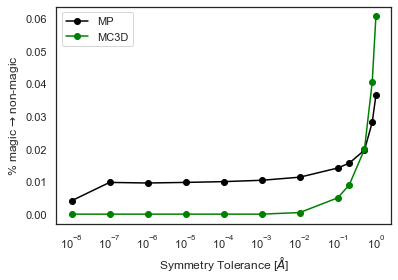

In [20]:
fig, ax_symm = plt.subplots(1, 1, 
                                       figsize=(6, 4), 
                                       sharey=True,)

mp_color = 'black'
exp_color = 'green'

ax_symm.semilogx(tols, 
                 perc_flip_mp,
                 marker='o',
                 label='MP',
                 color=mp_color,
          )

ax_symm.semilogx(tols, 
                 perc_flip_exp,
                 marker='o',
                 label='MC3D',
                 color=exp_color,
          )


ax_symm.legend()
ax_symm.set_xlabel(r"Symmetry Tolerance [$\AA$]")
ax_symm.set_ylabel(r"% magic $\to$ non-magic")
ax_symm.set_xticks(tols)

plt.savefig('perc_flip_symm_flip.png', bbox_inches='tight')
plt.show()

In [ ]:
! cd 

In [ ]:
fig, (ax_symm, ax_spec) = plt.subplots(1, 2, 
                                       figsize=(6, 4), 
                                       sharey=True,
                                       gridspec_kw=dict(width_ratios=(1.0, 0.2)))

mp_color = 'black'
exp_color = 'green'

ax_symm.semilogx(tols, 
                 perc_flip_mp,
                 marker='o',
                 label='MP',
                 color=mp_color,
          )

ax_symm.semilogx(tols, 
                 perc_flip_exp,
                 marker='o',
                 label='3DCD',
                 color=exp_color,
          )

ax_spec.axhline(perc_flip_mono_mp,
                color=mp_color,
                linestyle='dashed',
               )
ax_spec.axhline(perc_flip_mono_exp,
                color=exp_color,
                linestyle='dashed',
               )

ax_symm.legend()
ax_symm.set_xlabel(r"Symmetry Tolerance [$\AA$]")
ax_symm.set_ylabel(r"% magic $\to$ non-magic")
ax_symm.set_xticks(tols)
ax_spec.set_xticks([])
ax_spec.set_xlabel("Assuming\n1 Specie\nsymprec=1E-5$\AA$")
plt.savefig('perc_flip_symm_flip.png')
plt.show()

In [ ]:
n_mp_symm = [len(np.where(mp_symm[i]%4==0)[0])/len(mp_symm[0]) if min(mp_symm[i])>0 else np.nan for i in range(len(tols))]
n_exp_symm = [len(np.where(exp_symm[i]%4==0)[0])/len(exp_symm[0]) if min(exp_symm[i])>0 else np.nan for i in range(len(tols))]

n_mono_mp_symm = len(np.where(default_mono_mp_symm%4==0)[0])/len(mp_symm[0])
n_mono_exp_symm = len(np.where(default_mono_exp_symm%4==0)[0])/len(exp_symm[0])

In [ ]:
fig, (ax_symm, ax_spec) = plt.subplots(1, 2, 
                                       figsize=(6, 4), 
                                       sharey=True,
                                       gridspec_kw=dict(width_ratios=(1.0, 0.2)))

mp_color = 'black'
exp_color = 'green'

ax_symm.semilogx(tols, 
           n_mp_symm,
           marker='o',
             label='MP',
                 color=mp_color,
          )

ax_symm.semilogx(tols, 
           n_exp_symm,
           marker='o',
             label='3DCD',
                 color=exp_color,
          )

ax_spec.axhline(n_mono_mp_symm,
                color=mp_color,
                linestyle='dashed',
               )
ax_spec.axhline(n_mono_exp_symm,
                color=exp_color,
                linestyle='dashed',
               )

ax_symm.legend()
ax_symm.set_xlabel(r"Symmetry Tolerance [$\AA$]")
ax_symm.set_ylabel(r"% magic")
ax_symm.set_xticks(tols)
ax_spec.set_xticks([])
ax_spec.set_xlabel("Assuming\n1 Specie\nsymprec=1E-5$\AA$")
plt.savefig('symm_N.png')
plt.show()